In [1]:
import pandas as pd
import argparse
import collections
import csv
import simplejson as json
import random
import gc
import os
import glob
import numpy as np
import re
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 500)
pd.set_option("display.max_rows", 100)
pd.set_option('display.max_colwidth', -1)
#pd.set_option('display.max_colwidth', 0)

import xgboost as xgb
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC

from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix
#os.chdir("../project3/data/yelp_dataset_2020/selected/Round_3")
#os.chdir(os.getcwd())

#DO NOT RUN
#extension = 'csv'
#all_filenames = [i for i in glob.glob('*.{}'.format(extension))]
#df_scope_elite_19 = pd.concat([pd.read_csv(f, names=['user_id','elite_status']) for f in all_filenames ])
##export to csv
#df_scope_elite_19.to_csv( "yelp_selected_elites.csv", index=False, encoding='utf-8-sig')

In [2]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=18):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names, )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

In [ ]:
#Randomly Sampled -200000 Users are in both 2017,2018 data or in 2018 but started yelping in 2018
fin_test_yelp_users = pd.read_csv('../project3/groups/fin_test_users.csv')
positive_yelp_users = pd.read_csv('../project3/groups/positive_users.csv',)
sample_yelp_users = pd.read_csv('../project3/groups/sample_users.csv')

fin_test_yelp_users['group'] = 'fin_test_yelp_users'
positive_yelp_users['group'] = 'positive_yelp_users'
sample_yelp_users['group'] = 'sample_yelp_users'

scope_yelp_users = fin_test_yelp_users.append([positive_yelp_users, sample_yelp_users])

In [ ]:
df_user_18 = pd.read_csv('../project3/data/yelp_dataset_2019/user.csv')
df_user_18 = df_user_18.reindex(sorted(df_user_18.columns), axis=1)
df_user_18.drop_duplicates(keep=False,inplace=True) 
df_scope_user_18 = scope_yelp_users.merge(df_user_18, left_on='user_id', right_on='user_id').copy()

#del [[df_user_18]]
#gc.collect()

In [ ]:
df_scope_user_18['2018_elite_status'] = df_scope_user_18['elite'].str.contains('2018')
df_scope_user_18['2018_elite_status'].fillna(False, inplace = True)

In [ ]:
df_user_18['2018_elite_status'] = df_scope_user_18['elite'].str.contains('2018')
df_user_18['2018_elite_status'].fillna(False, inplace = True)

In [ ]:
elite_user_18 = df_user_18[['user_id', '2018_elite_status']]
elite_user_18.set_index('user_id', inplace = True)
elite_user_18_dict = elite_user_18.to_dict()['2018_elite_status']


def get_num_18_elite_friends(flist):
    try:
        return sum(map(lambda x: elite_user_18_dict[x], flist))
    except:
        return 0

In [ ]:
df_scope_user_18['friends'] = df_scope_user_18['friends'].apply(lambda x: [i.strip() for i in x.split(',')])
df_scope_user_18['num_2018_elite_friends'] = df_scope_user_18['friends'].apply(get_num_18_elite_friends)


In [ ]:
df_scope_user_18['num_2018_elite_friends'].fillna(0, inplace = True)

In [ ]:
df_user_18['elite_status'] = df_scope_user_18['elite'].notnull()
elite_user = df_user_18[['user_id', 'elite_status']]
elite_user.set_index('user_id', inplace = True)
elite_user_dict = elite_user.to_dict()['elite_status']


def get_num_elite_friends(flist):
    try:
        return sum(map(lambda x: elite_user_dict[x], flist))
    except:
        return 0

In [ ]:
df_scope_user_18['num_elite_friends'] = df_scope_user_18['friends'].apply(get_num_elite_friends)

In [ ]:
df_scope_user_18['num_elite_friends'].fillna(0, inplace = True)

In [ ]:
#DEFINTE SELECTED ELITES - not predicting 2019
#df_scope_elite_19 = pd.read_csv('../project3/data/yelp_dataset_2020/selected/Round_3/yelp_selected_elites.csv')
#df_scope_elite_19['2019_elite_status'] = df_scope_elite_19['elite_status'].str.contains('19')
#df_scope_user_18 = df_scope_user_18.merge(df_scope_elite_19, left_on='user_id', right_on='user_id').copy()

#del [[df_scope_elite_19]]
#gc.collect()

In [ ]:
df_scope_review_18 = pd.read_csv('../project3/2018_review.csv')

In [ ]:
#2018 RAW
#df_review_18 = pd.read_csv('../project3/data/yelp_dataset_2019/review.csv')
#df_review_18 = df_review_18.reindex(sorted(df_review_18.columns), axis=1)
#df_scope_review_18 = scope_yelp_users.merge(df_review_18, left_on='user_id', right_on='user_id').copy()

#del [[df_review_18]]
#gc.collect()

In [ ]:
df_scope_review_18.to_csv('../project3/2018_review.csv', index=False, encoding='utf-8-sig')

In [ ]:
df_tip_18 = pd.read_csv('../project3/data/yelp_dataset_2019/tip.csv')
df_tip_18 = df_tip_18.reindex(sorted(df_tip_18.columns), axis=1)
df_scope_tip_18 = scope_yelp_users.merge(df_tip_18, left_on='user_id', right_on='user_id').copy()

del [[df_tip_18]]
gc.collect()

In [ ]:
df_business_18 = pd.read_csv('../project3/data/yelp_dataset_2019/business.csv')
df_scope_tip_business_18 = df_scope_tip_18.merge(df_business_18, how='left', left_on='business_id', right_on='business_id').copy()
df_scope_review_business_18 = df_scope_review_18.merge(df_business_18, how='left', left_on='business_id', right_on='business_id', suffixes=('_review', '_business')).copy()

del [[df_business_18]]
gc.collect()


In [ ]:
#2017 Yelp Processing
df_user_17 = pd.read_csv('../project3/data/yelp_dataset_2018/yelp_academic_dataset_user.csv')
df_user_17 = df_user_17.reindex(sorted(df_user_17.columns), axis=1)
df_user_17.drop_duplicates(keep=False,inplace=True) 
df_scope_user_17 = scope_yelp_users.merge(df_user_17,how='left', left_on='user_id', right_on='user_id').copy()

del [[df_user_17]]
gc.collect()

In [ ]:
df_scope_review_17 = pd.read_csv('../project3/2017_review.csv')

In [ ]:
#df_review_17 = pd.read_csv('../project3/data/yelp_dataset_2018/yelp_academic_dataset_review.csv')
#df_scope_review_17 = scope_yelp_users.merge(df_review_17, left_on='user_id', right_on='user_id').copy()

#del [[df_review_17]]
#gc.collect()

In [ ]:
#df_scope_review_17.to_csv('../project3/2017_review.csv', index=False, encoding='utf-8-sig')

In [ ]:
df_tip_17 = pd.read_csv('../project3/data/yelp_dataset_2018/yelp_academic_dataset_tip.csv')
df_scope_tip_17 = scope_yelp_users.merge(df_tip_17, left_on='user_id', right_on='user_id').copy()

del [[df_tip_17]]
gc.collect()

In [ ]:
df_business_17 = pd.read_csv('../project3/data/yelp_dataset_2018/yelp_academic_dataset_business.csv')
df_scope_tip_business_17 = df_scope_tip_17.merge(df_business_17, how='left', left_on='business_id', right_on='business_id').copy()
df_scope_review_business_17 = df_scope_review_17.merge(df_business_17, how='left', left_on='business_id', right_on='business_id',suffixes=('_review', '_business')).copy()

del [[df_business_17]]
gc.collect()

In [ ]:
df_scope_review_business_17

In [ ]:
#df_scope_tip_business_18
#df_scope_review_business_18
#df_scope_user_18
#df_scope_tip_business_17
#df_scope_review_business_17
#df_scope_user_17

In [ ]:
#2017 RAW
#df_review_17 = pd.read_csv('../project3/data/yelp_dataset_2018/yelp_academic_dataset_review.csv', nrows=1000)
#df_user_17 = pd.read_csv('../project3/data/yelp_dataset_2018/yelp_academic_dataset_user.csv', nrows=1000)
#df_tip_17 = pd.read_csv('../project3/data/yelp_dataset_2018/yelp_academic_dataset_tip.csv', nrows=1000)
#df_business_17 = pd.read_csv('../project3/data/yelp_dataset_2018/yelp_academic_dataset_business.csv', nrows=1000)
#df_checkin_17 = pd.read_csv('../project3/data/yelp_dataset_2018/yelp_academic_dataset_checkin.csv', nrows=1000)

In [ ]:
#df_scope_tip_business_18
#df_scope_review_business_18
#df_scope_user_18

In [ ]:
df_scope_tip_18['date'] = pd.to_datetime(df_scope_tip_18['date']) 
df_scope_tip_17_18 = df_scope_tip_18[(df_scope_tip_18['date'].dt.year == 2018) | (df_scope_tip_18['date'].dt.year == 2017)]
df_scope_tip_17_18['count_words'] = df_scope_tip_17_18['text'].apply(lambda x: len(str(x).split(' ')))
df_scope_tip_17_18['count_chars'] = df_scope_tip_17_18['text'].str.len()


grouped_df_scope_tip_17_18 = df_scope_tip_17_18.groupby([df_scope_tip_17_18['date'].dt.year, df_scope_tip_17_18['user_id']]) \
       .agg({'compliment_count':'sum', 'count_words':'mean','count_chars':'mean'}) \
       .rename(columns={'compliment_count':'num_compliment','count_words':'mean_compliment_num_word','count_chars':'mean_compliment_num_chars'}) \
       .reset_index() \
       .sort_values(['user_id','date'],ascending=False)


In [ ]:
flat_grouped_df_scope_tip_17_18 = grouped_df_scope_tip_17_18.pivot(index='user_id',\
                                                                                           columns='date'
                                                                                          ).reset_index()
flat_grouped_df_scope_tip_17_18.columns = flat_grouped_df_scope_tip_17_18.columns.map('{0[0]}_{0[1]}'.format) 

In [ ]:
flat_grouped_df_scope_tip_17_18.rename(columns={'user_id_':'user_id'}, inplace=True)
flat_grouped_df_scope_tip_17_18.fillna(0, inplace=True)

In [ ]:
#flat_grouped_df_scope_tip_17_18.to_csv('../project3/flat_grouped_df_scope_tip_17_18.csv', index=False, encoding='utf-8-sig')

flat_grouped_df_scope_tip_17_18 = pd.read_csv('../project3/flat_grouped_df_scope_tip_17_18.csv)



In [ ]:
flat_grouped_df_scope_tip_17_18

In [ ]:
#engineer reviews 2018
df_scope_review_business_18['date'] = pd.to_datetime(df_scope_review_business_18['date']) 
df_scope_review_business_18['count_words'] = df_scope_review_business_18['text'].apply(lambda x: len(str(x).split(' ')))
df_scope_review_business_18['count_chars'] = df_scope_review_business_18['text'].str.len()
df_scope_review_business_18['user_to_mean_variance'] = (df_scope_review_business_18['stars_business'] - df_scope_review_business_18['stars_review'])**2
df_scope_review_business_18['categories'] = df_scope_review_business_18['categories'].astype(str)



In [ ]:
df_scope_review_business_17_18 = df_scope_review_business_18[(df_scope_review_business_18['date'].dt.year == 2018) | (df_scope_review_business_18['date'].dt.year == 2017)]


In [ ]:
grouped_df_scope_review_business_17_18 = df_scope_review_business_17_18.groupby([df_scope_review_business_17_18['date'].dt.year,df_scope_review_business_17_18['user_id']]) \
       .agg({'review_id':'count', 'count_words':'mean','count_chars':'mean', 'user_to_mean_variance': 'mean',\
             'categories': ','.join}) \
       .rename(columns={'review_id':'num_reviews','count_words':'mean_review_num_word','count_chars':'mean_review_num_chars',\
                        'user_to_mean_variance':'mean_review_varience', 'categories': 'unique_categories'}) \
       .reset_index() \
       .sort_values(['user_id','date'],ascending=False)


In [ ]:
flat_grouped_df_scope_review_business_17_18 = grouped_df_scope_review_business_17_18.pivot(index='user_id',\
                                                                                           columns='date'
                                                                                          ).reset_index()
flat_grouped_df_scope_review_business_17_18.columns = flat_grouped_df_scope_review_business_17_18.columns.map('{0[0]}_{0[1]}'.format) 

In [ ]:
flat_grouped_df_scope_review_business_17_18.rename(columns={'user_id_':'user_id'}, inplace=True)
#flat_grouped_df_scope_review_business_17_18.fillna(0, inplace = True)
#flat_grouped_df_scope_review_business_17_18
flat_grouped_df_scope_review_business_17_18['unique_categories_2018']=flat_grouped_df_scope_review_business_17_18['unique_categories_2018'].\
apply(lambda x: len(np.unique(np.array([i.strip() for i in x.split(",")]))) if pd.notnull(x) else None
     )
flat_grouped_df_scope_review_business_17_18['unique_categories_2017']=flat_grouped_df_scope_review_business_17_18['unique_categories_2017'].\
apply(lambda x: len(np.unique(np.array([i.strip() for i in x.split(",")]))) if pd.notnull(x) else None
     )
flat_grouped_df_scope_review_business_17_18.fillna(0, inplace = True)


In [ ]:
#flat_grouped_df_scope_review_business_17_18.to_csv('../project3/flat_grouped_df_scope_review_business_17_18.csv', index=False, encoding='utf-8-sig')

flat_grouped_df_scope_review_business_17_18 = pd.read_csv('../project3/flat_grouped_df_scope_review_business_17_18.csv)



In [ ]:
#df_scope_user_18['friends'].map(lambda x: len([i.strip() for i in x.split(",")]) if pd.notnull(x) else None)
#map(lambda x: len([i.strip() for i in str(x).split(",")]) if pd.notnull(x) else None)
df_scope_user_18['friends'].replace('None',np.NaN,inplace=True)

def sum_friends(flist):
    try:
        return sum(map(lambda x: 1 if str(x) != 'None' or str(x) != NaN else 0, flist))
    except:
        return 0

df_scope_user_18['num_friends'] = df_scope_user_18['friends'].apply(sum_friends)
    

In [ ]:
#engineer user 2018
df_scope_user_18['friends'].replace('None',np.NaN,inplace=True)
df_scope_user_18['2017_elite_status'] = df_scope_user_18['elite'].str.contains('2017')
df_scope_user_18['num_years_elite'] = df_scope_user_18['elite'].map(lambda x: len([i.strip() for i in str(x).split(",")]) if pd.notnull(x) else None)
#df_scope_user_18['elite'].fillna(0, inplace=True)
df_scope_user_18['num_compliments'] = df_scope_user_18[['compliment_cool', 'compliment_cute', 'compliment_funny', 'compliment_hot', 'compliment_list', 'compliment_more', 'compliment_note', 'compliment_photos', 'compliment_plain', 'compliment_profile', 'compliment_writer']].sum(axis=1)
df_scope_user_18['num_votes'] = df_scope_user_18[['cool','funny','useful']].sum(axis=1)
df_scope_user_18['yelping_since'] = pd.to_datetime(df_scope_user_18['yelping_since'])
end_date_18 = pd.to_datetime("12/31/2018")
df_scope_user_18['num_days_acct_created'] = (end_date_18-df_scope_user_18['yelping_since']).dt.days
df_scope_user_18['num_years_elite'].fillna(0, inplace = True) 
df_scope_user_18['2017_elite_status'].fillna(False, inplace = True)
#df_scope_user_18['2017_elite_status'] = df_scope_user_18['2017_elite_status'].astype(int)





In [ ]:
df_scope_user_17


In [ ]:
#engineer user 2017
df_scope_user_17['num_friends'] = df_scope_user_17['friends'].map(lambda x: len([i.strip() for i in x.split(",")]) if pd.notnull(x) else None)
df_scope_user_17['friends'].replace('None',np.NaN,inplace=True)
df_scope_user_17['num_years_elite'] = df_scope_user_17['elite'].map(lambda x: len([i.strip() for i in str(x).split(",")]) if pd.notnull(x) and x != 'None' else 0)
df_scope_user_17['num_compliments'] = df_scope_user_17[['compliment_cool', 'compliment_cute', 'compliment_funny', 'compliment_hot', 'compliment_list', 'compliment_more', 'compliment_note', 'compliment_photos', 'compliment_plain', 'compliment_profile', 'compliment_writer']].sum(axis=1)
df_scope_user_17['num_votes'] = df_scope_user_17[['cool','funny','useful']].sum(axis=1)
end_date_17 = pd.to_datetime("12/31/2017")
df_scope_user_17['num_years_elite'].fillna(0, inplace = True) 



In [ ]:
df_scope_user_17_18 = df_scope_user_18.merge(df_scope_user_17, how='inner', left_on='user_id', right_on='user_id',suffixes=('_data_2018', '_data_2017')).copy()
df_scope_user_17_18 = df_scope_user_17_18.merge(flat_grouped_df_scope_review_business_17_18, how='left', left_on='user_id', right_on='user_id')
df_scope_user_17_18 = df_scope_user_17_18.merge(flat_grouped_df_scope_tip_17_18, how='left', left_on='user_id', right_on='user_id', suffixes=('', '_datatip'))
df_scope_user_17_18 = df_scope_user_17_18.reindex(sorted(df_scope_user_17_18.columns), axis=1)



In [3]:
#df_scope_user_17_18.to_csv('../project3/df_scope_user_17_18.csv', index=False, encoding='utf-8-sig')

df_scope_user_17_18 = pd.read_csv('../project3/df_scope_user_17_18.csv')



In [4]:
#SET FEATURES for LOG (No Nulls Allowed)
#df_scope_user_17_18['2019_elite_status'].fillna(False, inplace=True)
df_scope_user_17_18['num_votes_delta'] = df_scope_user_17_18['num_votes_data_2018'] - df_scope_user_17_18['num_votes_data_2017']
df_scope_user_17_18['num_compliments_delta'] = df_scope_user_17_18['num_compliments_data_2018'] - df_scope_user_17_18['num_compliments_data_2017']
df_scope_user_17_18['num_friends_delta'] = df_scope_user_17_18['num_friends_data_2018'] - df_scope_user_17_18['num_friends_data_2017']
df_scope_user_17_18['review_count_delta'] = df_scope_user_17_18['review_count_data_2018'] - df_scope_user_17_18['review_count_data_2017']
df_scope_user_17_18['fans_delta'] = df_scope_user_17_18['fans_data_2018'] - df_scope_user_17_18['fans_data_2017']

#df_scope_user_17_18['_delta'] = df_scope_user_17_18['_2018'] - df_scope_user_17_18['_2017']



In [5]:
df = df_scope_user_17_18

In [ ]:
df[df['group_data_2018'] == 'fin_test_yelp_users']

In [80]:
df[df['user_id']=='oazuTtSyKV6zrhbsgbdbUQ']

,2017_elite_status,2018_elite_status,average_stars_data_2017,average_stars_data_2018,compliment_cool_data_2017,compliment_cool_data_2018,compliment_cute_data_2017,compliment_cute_data_2018,compliment_funny_data_2017,compliment_funny_data_2018,compliment_hot_data_2017,compliment_hot_data_2018,compliment_list_data_2017,compliment_list_data_2018,compliment_more_data_2017,compliment_more_data_2018,compliment_note_data_2017,compliment_note_data_2018,compliment_photos_data_2017,compliment_photos_data_2018,compliment_plain_data_2017,compliment_plain_data_2018,compliment_profile_data_2017,compliment_profile_data_2018,compliment_writer_data_2017,compliment_writer_data_2018,cool_data_2017,cool_data_2018,elite_data_2017,elite_data_2018,fans_data_2017,fans_data_2018,friends_data_2017,friends_data_2018,funny_data_2017,funny_data_2018,group_data_2017,group_data_2018,mean_compliment_num_chars_2017,mean_compliment_num_chars_2018,mean_compliment_num_word_2017,mean_compliment_num_word_2018,mean_review_num_chars_2017,mean_review_num_chars_2018,mean_review_num_word_2017,mean_review_num_word_2018,mean_review_varience_2017,mean_review_varience_2018,name_data_2017,name_data_2018,num_2018_elite_friends,num_compliment_2017,num_compliment_2018,num_compliments_data_2017,num_compliments_data_2018,num_days_acct_created,num_elite_friends,num_friends_data_2017,num_friends_data_2018,num_reviews_2017,num_reviews_2018,num_votes_data_2017,num_votes_data_2018,num_years_elite_data_2017,num_years_elite_data_2018,review_count_data_2017,review_count_data_2018,unique_categories_2017,unique_categories_2018,useful_data_2017,useful_data_2018,user_id,yelping_since_data_2017,yelping_since_data_2018,num_votes_delta,num_compliments_delta,num_friends_delta,review_count_delta,fans_delta
24314,True,True,4.54,4.59,3848.0,5242,113.0,142,3848.0,5242,2331.0,3236,46.0,70,78.0,109,830.0,1256,2874.0,4329,2879.0,3869,105.0,185,586.0,863,78040.0,31895,"2016, 2015, 2017","2015,2016,2017,2018",433.0,861,"oNII0l8kb83PbqGzDN4yCA, LbWCIaWnwkuRcUF4gNsiTw...","['N6S6h8kFXk0tuxPSiZKCMw', '0l-6FG2dqWJIlQIBeE...",15172.0,20909,fin_test_yelp_users,fin_test_yelp_users,0.0,40.5,0.0,7.25,0.0,977.0,0.0,166.0,0.0,0.25,Elle,Elle,0,0.0,3.0,17538.0,24543,2550,0.0,3011.0,3781,0.0,1.0,107281.0,85366,3,4.0,467.0,564,0.0,3.0,14069.0,32562,oazuTtSyKV6zrhbsgbdbUQ,2012-01-06,2012-01-06 06:11:29,-21915.0,7005.0,770.0,97.0,428.0


In [6]:
df['review_count_delta'].fillna(0, inplace = True)
df['num_votes_delta'].fillna(0, inplace = True)
df['num_compliments_delta'].fillna(0, inplace = True)
df['num_years_elite_data_2017'].fillna(0, inplace = True)
df['fans_delta'].fillna(0, inplace = True)
df['average_stars_data_2018'].fillna(0, inplace = True)
df['2017_elite_status'].fillna(0, inplace = True)
df['mean_review_num_chars_2018'].fillna(0, inplace = True)
df['mean_review_num_word_2018'].fillna(0, inplace = True)
df['unique_categories_2018'].fillna(0, inplace = True)
df['num_reviews_2018'].fillna(0, inplace = True)

In [7]:
df_test = df[df['group_data_2018'] == 'fin_test_yelp_users']

df_train = df[df['group_data_2018'] != 'fin_test_yelp_users']

In [30]:
x_train = df_train[['review_count_delta','num_votes_delta',
                                                        'num_compliments_delta','num_years_elite_data_2017',
                                                        'fans_delta','average_stars_data_2018','2017_elite_status',
                                                        'mean_review_num_chars_2018','mean_review_num_word_2018','num_days_acct_created',
                                                        'unique_categories_2018','num_elite_friends','review_count_data_2018'                                                       ]]

y_train = df_train['2018_elite_status']

x_test = df_test[['review_count_delta','num_votes_delta',
                                                        'num_compliments_delta','num_years_elite_data_2017',
                                                        'fans_delta','average_stars_data_2018','2017_elite_status',
                                                        'mean_review_num_chars_2018','mean_review_num_word_2018','num_days_acct_created',
                                                        'unique_categories_2018','num_elite_friends','review_count_data_2018'                
                                                       ]]

y_test = df_test['2018_elite_status']


In [31]:
x_test, x_val, y_test, y_val = train_test_split(x_test, 
                                                    y_test, 
                                                    test_size = 0.5, random_state=42)

In [32]:
#BOOSTING!
gbm = xgb.XGBClassifier( 
                        n_estimators=30000,
                        max_depth=6,
                        objective='binary:logistic', #new objective
                        learning_rate=.045, #.05 
                        subsample=.8, #.8
                        scale_pos_weight = 1,
                        gamma = .5,
                        min_child_weight=3,
                        colsample_bytree=.75        
                           )

eval_set=[(x_train,y_train),(x_test,y_test)]
fit_model = gbm.fit( 
                    x_train, y_train, 
                    eval_set=eval_set,
                    eval_metric='error', #new evaluation metric: classification error (could also use AUC, e.g.)
                    early_stopping_rounds=50,
                    verbose=False
                   )

#predicted_new_threshold_adjusted=(pipe.predict_proba(X_new)>threshold).astype(int)

#y_pred = fit_model.predict(x_test, ntree_limit=gbm.best_ntree_limit)
#y_pred = fit_model.predict(x_test, ntree_limit=gbm.best_ntree_limit)

y_pred = (fit_model.predict_proba(x_val, ntree_limit=gbm.best_ntree_limit)[:,1] >= .50)

print("Default threshold:")
print("Accuracy: {:6.5f}, Precision: {:6.5f},   Recall: {:6.5f}, F1_score: {:6.5f}".format(
                    accuracy_score(y_val, y_pred),
                    precision_score(y_val, y_pred),
                    recall_score(y_val, y_pred),
                    f1_score(y_val, y_pred)
))


#Accuracy: 0.99445, Precision: 0.91354,   Recall: 0.86319, F1_score: 0.88765 without friends
#Accuracy: 0.99460, Precision: 0.91667,   Recall: 0.86614, F1_score: 0.89069 with friends
#Accuracy: 0.99465, Precision: 0.90752,   Recall: 0.87894, F1_score: 0.89300 with varience stat
#Accuracy: 0.99473, Precision: 0.91624,   Recall: 0.87205, F1_score: 0.89360 with category counts
#Accuracy: 0.99473, Precision: 0.91538,   Recall: 0.87303, F1_score: 0.89370
#Accuracy: 0.99498, Precision: 0.91371,   Recall: 0.88583, F1_score: 0.89955
#Accuracy: 0.99515, Precision: 0.91939,   Recall: 0.88681, F1_score: 0.90281
#Accuracy: 0.99520, Precision: 0.91700,   Recall: 0.89173, F1_score: 0.90419
#Accuracy: 0.98685, Precision: 0.95418,   Recall: 0.96822, F1_score: 0.96115
#Accuracy: 0.98725, Precision: 0.95438,   Recall: 0.97043, F1_score: 0.96234
#Accuracy: 0.98608, Precision: 0.63651,   Recall: 0.97236, F1_score: 0.76938
#Accuracy: 0.98614, Precision: 0.63756,   Recall: 0.97236, F1_score: 0.77015
#Accuracy: 0.98550, Precision: 0.62520,   Recall: 0.98074, F1_score: 0.76361
#Accuracy: 0.98618, Precision: 0.63872,   Recall: 0.96985, F1_score: 0.77020
#
#


Default threshold:
Accuracy: 0.98496, Precision: 0.62324,   Recall: 0.97633, F1_score: 0.76081


In [169]:
import tqdm
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold


In [170]:

kfold = KFold(n_splits=2)
#cross_val_score(fit_model, x_train, y_train, cv=kfold, verbose=True)

results = cross_val_score(fit_model, x_train, y_train, cv=10, scoring='neg_log_loss', n_jobs=-1)


KeyboardInterrupt: 

In [145]:
fit_model.predict_proba(x_test, ntree_limit=gbm.best_ntree_limit)[:,1].min()

0.45616624

In [146]:
from sklearn.metrics import roc_curve, auc, classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       1.00      0.99      0.99     48806
        True       0.64      0.97      0.77      1194

    accuracy                           0.99     50000
   macro avg       0.82      0.98      0.88     50000
weighted avg       0.99      0.99      0.99     50000



In [147]:
conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
conf_mat

array([[48146,   660],
       [   33,  1161]])

In [182]:
log = LogisticRegression()
log.fit(x_train, y_train)

/Users/chen/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [185]:
y_predict = log.predict(x_val)

print("Default threshold:")
print("Accuracy: {:6.5f}, Precision: {:6.5f},   Recall: {:6.5f}, F1_score: {:6.5f}".format(
                    log.score(x_val, y_val),
                    precision_score(y_val, y_predict), 
                    recall_score(y_val, y_predict),
                    f1_score(y_val, y_predict)
))

#Accuracy: 0.98523, Precision: 0.84330,   Recall: 0.51378, F1_score: 0.63853 base line
#Accuracy: 0.98618, Precision: 0.81931,   Recall: 0.58465, F1_score: 0.68237 with 2018 mean review counts and word
#Accuracy: 0.98668, Precision: 0.83871,   Recall: 0.58858, F1_score: 0.69173 with num days acct created 2018
#Accuracy: 0.98590, Precision: 0.83832,   Recall: 0.55118, F1_score: 0.66508 with unique categories count


Default threshold:
Accuracy: 0.97946, Precision: 0.55010,   Recall: 0.88735, F1_score: 0.67916


In [ ]:
x_test['pred_y'] = log.predict(x_test)

In [ ]:
x_test = pd.merge(x_test,y_test ,how = 'left',left_index = True, right_index = True)


In [ ]:
df_pred = pd.merge(x_test,df,how = 'left',left_index = True, right_index = True)

In [ ]:
precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_test, log.predict_proba(x_test)[:,1] )

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label as fraud)');
plt.title('Precision and Recall Curves');

In [ ]:

plt.figure(dpi=80)
plt.plot(recall_curve[1:], precision_curve[1:],label='precision')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve");

In [ ]:
# Precision = TP / (TP + FP)
# Recall = TP/P = True positive rate
# false positive rate = FP / true negatives = FP / (FP + TN) 
from sklearn.metrics import roc_auc_score, roc_curve

fpr, tpr, thresholds = roc_curve(y_test, log.predict_proba(x_test)[:,1])

In [ ]:
plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for fraud problem');
print("ROC AUC score = ", roc_auc_score(y_test, log.predict_proba(x_test)[:,1]))

In [ ]:
def plot_features(df, sample_size=500):
    
    sample = (df.drop(['user_id'],axis=1)
                .sample(1000, random_state=44)) 
    sns.pairplot(sample,hue='2019_elite_status', plot_kws=dict(alpha=.3, edgecolor='none'))

plot_features(df)

In [80]:
#BOOSTING!

gbm = xgb.XGBClassifier( 
                        n_estimators=30000,
                        max_depth=6,
                        objective='binary:logistic', #new objective
                        learning_rate=.045, #.05 
                        subsample=.8, #.8
                        scale_pos_weight = 1,
                        gamma = .5,
                        min_child_weight=3,
                        colsample_bytree=.75        
                           )

eval_set=[(x_train,y_train),(x_test,y_test)]
fit_model = gbm.fit( 
                    x_train, y_train, 
                    eval_set=eval_set,
                    eval_metric='error', #new evaluation metric: classification error (could also use AUC, e.g.)
                    early_stopping_rounds=50,
                    verbose=False
                   )

print("Default threshold:")
print("Accuracy: {:6.5f}, Precision: {:6.5f},   Recall: {:6.5f}, F1_score: {:6.5f}".format(
                    accuracy_score(y_test, fit_model.predict(x_test, ntree_limit=gbm.best_ntree_limit)),
                    precision_score(y_test, fit_model.predict(x_test, ntree_limit=gbm.best_ntree_limit)),
                    recall_score(y_test, fit_model.predict(x_test, ntree_limit=gbm.best_ntree_limit)),
                    f1_score(y_test, fit_model.predict(x_test, ntree_limit=gbm.best_ntree_limit))
))


#Accuracy: 0.99445, Precision: 0.91354,   Recall: 0.86319, F1_score: 0.88765 without friends
#Accuracy: 0.99460, Precision: 0.91667,   Recall: 0.86614, F1_score: 0.89069 with friends
#Accuracy: 0.99465, Precision: 0.90752,   Recall: 0.87894, F1_score: 0.89300 with varience stat
#Accuracy: 0.99473, Precision: 0.91624,   Recall: 0.87205, F1_score: 0.89360 with category counts
#Accuracy: 0.99473, Precision: 0.91538,   Recall: 0.87303, F1_score: 0.89370
#Accuracy: 0.99498, Precision: 0.91371,   Recall: 0.88583, F1_score: 0.89955
#Accuracy: 0.99515, Precision: 0.91939,   Recall: 0.88681, F1_score: 0.90281
#Accuracy: 0.99520, Precision: 0.91700,   Recall: 0.89173, F1_score: 0.90419

#Accuracy: 0.98685, Precision: 0.95418,   Recall: 0.96822, F1_score: 0.96115
#Accuracy: 0.98725, Precision: 0.95438,   Recall: 0.97043, F1_score: 0.96234
#Accuracy: 0.98608, Precision: 0.63651,   Recall: 0.97236, F1_score: 0.76938
#Accuracy: 0.98614, Precision: 0.63756,   Recall: 0.97236, F1_score: 0.77015
#Accuracy: 0.98550, Precision: 0.62520,   Recall: 0.98074, F1_score: 0.76361
#Accuracy: 0.98618, Precision: 0.63872,   Recall: 0.96985, F1_score: 0.77020

#

Default threshold:
Accuracy: 0.98618, Precision: 0.63872,   Recall: 0.96985, F1_score: 0.77020


In [33]:
randomforest = RandomForestClassifier(n_estimators=1000) #100
randomforest.fit(x_train, y_train)

y_predict = randomforest.predict(x_test)

print("Default threshold:")
print("Accuracy: {:6.5f}, Precision: {:6.5f},   Recall: {:6.5f}, F1_score: {:6.5f}".format(
                    randomforest.score(x_test, y_test),
                    precision_score(y_test, y_predict), 
                    recall_score(y_test, y_predict),
                    f1_score(y_test, y_predict)))

Default threshold:
Accuracy: 0.98590, Precision: 0.63138,   Recall: 0.98409, F1_score: 0.76923


In [189]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)
{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}



#Accuracy: 0.99438, Precision: 0.91852,   Recall: 0.85433, F1_score: 0.88526
#Accuracy: 0.98564, Precision: 0.62687,   Recall: 0.98492, F1_score: 0.76612


{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42)
# Fit the random search model
rf_random.fit(x_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=True 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=True, total=   7.9s
[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=True 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.9s remaining:    0.0s


[CV]  n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=True, total=  19.9s
[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=True 
[CV]  n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=True, total=  20.9s
[CV] n_estimators=2000, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=10, bootstrap=True 
[CV]  n_estimators=2000, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=10, bootstrap=True, total=  29.7s
[CV] n_estimators=2000, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=10, bootstrap=True 
[CV]  n_estimators=2000, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=10, bootstrap=True, total= 1.1min
[CV] n_estimators=2000, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=10, bootstrap=True 
[CV]  n_estimators=2000, min_sa

In [ ]:
y_predict = randomforest.predict(x_test)

print("Default threshold:")
print("Accuracy: {:6.5f}, Precision: {:6.5f},   Recall: {:6.5f}, F1_score: {:6.5f}".format(
                    randomforest.score(x_test, y_test),
                    precision_score(y_test, y_predict), 
                    recall_score(y_test, y_predict),
                    f1_score(y_test, y_predict)))

#Accuracy: 0.99438, Precision: 0.91852,   Recall: 0.85433, F1_score: 0.88526
#Accuracy: 0.98564, Precision: 0.62687,   Recall: 0.98492, F1_score: 0.76612

In [21]:
from sklearn import metrics
from sklearn.model_selection import cross_val_score
scores = cross_val_score(
randomforest, df[['review_count_delta','num_votes_delta',
                                                        'num_compliments_delta','num_years_elite_data_2017',
                                                        'fans_delta','average_stars_data_2018','2017_elite_status',
                                                        'mean_review_num_chars_2018','mean_review_num_word_2018','num_days_acct_created',
                                                        'unique_categories_2018','num_elite_friends','review_count_data_2018'
                                                       ]], df['2018_elite_status'], cv=5, scoring='f1_macro')

In [22]:
scores

array([0.98130239, 0.97419049, 0.9789267 , 0.97360605, 0.97152209])

In [30]:
y_pred = fit_model.predict(x_test)
conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
conf_mat
#cm = print_confusion_matrix(conf_mat, ['Class 0', 'Class 1'])

array([[96251,  1330],
       [   71,  2348]])

In [ ]:
x_test['pred_y'] = gbm.predict(x_test)

In [ ]:
x_test['pred_proba'] = gbm.predict_proba(x_test)[:,1]

In [ ]:
x_test = pd.merge(x_test,y_test ,how = 'left',left_index = True, right_index = True)


In [ ]:
df_pred = pd.merge(x_test,df,how = 'left',left_index = True, right_index = True)

In [79]:
pd.reset_option('display.max_colwidth')

In [ ]:
df_pred[(df_pred['2018_elite_status'] == 1) & (df_pred['pred_proba'] > .5)]

In [ ]:
df_pred[(df_pred['2018_elite_status'] == 0) & (df_pred['pred_proba'] > .5)].sort_values(['pred_proba'],ascending=False)


In [ ]:
df_scope_review_business_18[df_scope_review_business_18['user_id']=='L_Ft1kZRot-UIlDf6WS9iQ']

# DID NOT USE MODELS

In [18]:
LSVC = LinearSVC()
LSVC.fit(x_train, y_train)
y_pred = LSVC.predict(x_test)
print(metrics.accuracy_score(y_test, y_pred))

y_predict = LSVC.predict(x_test)

print("Default threshold:")
print("Accuracy: {:6.5f}, Precision: {:6.5f},   Recall: {:6.5f}, F1_score: {:6.5f}".format(
                    LSVC.score(x_test, y_test),
                    precision_score(y_test, y_predict), 
                    recall_score(y_test, y_predict),
                    f1_score(y_test, y_predict)))

#Accuracy: 0.98850, Precision: 0.81027,   Recall: 0.71457, F1_score: 0.75941


0.9683
Default threshold:
Accuracy: 0.96830, Precision: 0.42789,   Recall: 0.97152, F1_score: 0.59411


/Users/chen/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [19]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(x_train, y_train)
y_predict = knn.predict(x_test)

print("Default threshold:")
print("Accuracy: {:6.5f}, Precision: {:6.5f},   Recall: {:6.5f}, F1_score: {:6.5f}".format(
                    knn.score(x_test, y_test),
                    precision_score(y_test, y_predict), 
                    recall_score(y_test, y_predict),
                    f1_score(y_test, y_predict)))

Default threshold:
Accuracy: 0.95086, Precision: 0.31690,   Recall: 0.91541, F1_score: 0.47082


In [52]:
DT = DecisionTreeClassifier(max_depth=7)
DT.fit(x_train, y_train)
y_predict = DT.predict(x_test)

print("Default threshold:")
print("Accuracy: {:6.5f}, Precision: {:6.5f},   Recall: {:6.5f}, F1_score: {:6.5f}".format(
                    DT.score(x_test, y_test),
                    precision_score(y_test, y_predict), 
                    recall_score(y_test, y_predict),
                    f1_score(y_test, y_predict)))

#Accuracy: 0.99375, Precision: 0.88765,   Recall: 0.86319, F1_score: 0.87525 
#Accuracy: 0.99410, Precision: 0.90206,   Recall: 0.86122, F1_score: 0.88117 with category

Default threshold:
Accuracy: 0.98356, Precision: 0.59773,   Recall: 0.97974, F1_score: 0.74248


In [13]:
randomforest = RandomForestClassifier(n_estimators=1000) #100
randomforest.fit(x_train, y_train)

y_predict = randomforest.predict(x_test)

print("Default threshold:")
print("Accuracy: {:6.5f}, Precision: {:6.5f},   Recall: {:6.5f}, F1_score: {:6.5f}".format(
                    randomforest.score(x_test, y_test),
                    precision_score(y_test, y_predict), 
                    recall_score(y_test, y_predict),
                    f1_score(y_test, y_predict)))

#Accuracy: 0.99438, Precision: 0.91852,   Recall: 0.85433, F1_score: 0.88526

Default threshold:
Accuracy: 0.98530, Precision: 0.62149,   Recall: 0.98325, F1_score: 0.76160


In [21]:

y_predict = randomforest.predict(x_val)

print("Default threshold:")
print("Accuracy: {:6.5f}, Precision: {:6.5f},   Recall: {:6.5f}, F1_score: {:6.5f}".format(
                    randomforest.score(x_val, y_val),
                    precision_score(y_val, y_predict), 
                    recall_score(y_val, y_predict),
                    f1_score(y_val, y_predict)))

#Accuracy: 0.99438, Precision: 0.91852,   Recall: 0.85433, F1_score: 0.88526

Default threshold:
Accuracy: 0.98582, Precision: 0.63536,   Recall: 0.98857, F1_score: 0.77355


In [35]:
feature_importances = pd.DataFrame(randomforest.feature_importances_,
                                   index = x_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)



In [90]:
pd.DataFrame(feature_importances.index).replace('_',' ').title()

AttributeError: 'DataFrame' object has no attribute 'title'

In [92]:
feature_importances.index.str.replace('_',' ').str.title()

Index(['2017 Elite Status', 'Num Compliments Delta', 'Review Count Delta', 'Review Count Data 2018', 'Num Years Elite Data 2017', 'Fans Delta', 'Num Votes Delta', 'Num Friends Data 2018', 'Num Days Acct Created', 'Average Stars Data 2018', 'Unique Categories 2018', 'Mean Review Num Chars 2018', 'Mean Review Num Word 2018', 'Num Elite Friends'], dtype='object')

In [87]:
print(feature_importances.index.str.split('_'))

Index([['2017', 'elite', 'status'], ['num', 'compliments', 'delta'], ['review', 'count', 'delta'], ['review', 'count', 'data', '2018'], ['num', 'years', 'elite', 'data', '2017'], ['fans', 'delta'], ['num', 'votes', 'delta'], ['num', 'friends', 'data', '2018'], ['num', 'days', 'acct', 'created'], ['average', 'stars', 'data', '2018'], ['unique', 'categories', '2018'], ['mean', 'review', 'num', 'chars', '2018'], ['mean', 'review', 'num', 'word', '2018'], ['num', 'elite', 'friends']], dtype='object')


In [86]:
feature_importances.index

Index(['2017_elite_status', 'num_compliments_delta', 'review_count_delta', 'review_count_data_2018', 'num_years_elite_data_2017', 'fans_delta', 'num_votes_delta', 'num_friends_data_2018', 'num_days_acct_created', 'average_stars_data_2018', 'unique_categories_2018', 'mean_review_num_chars_2018', 'mean_review_num_word_2018', 'num_elite_friends'], dtype='object')

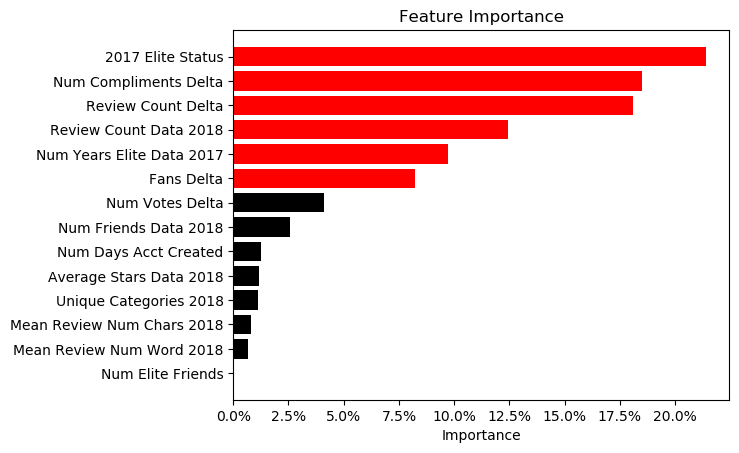

In [93]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as mtick

# Actual plotting code omitted


plt.rcdefaults()

fig, ax = plt.subplots()
my_colors = ['red','red', 'red', 'red', 'red', 'red','black','black','black','black','black','black','black'] 
ax.barh(feature_importances.index.str.replace('_',' ').str.title(), feature_importances['importance'], align='center',color=my_colors)

#ax.set_yticks(y_pos)
#ax.set_yticklabels(people)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Importance')
ax.set_title('Feature Importance')
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))


In [25]:
conf_mat = confusion_matrix(y_true=y_val, y_pred=y_predict)
conf_mat


array([[48080,   695],
       [   14,  1211]])

In [54]:
nb = GaussianNB()
nb.fit(x_train, y_train)

y_predict = nb.predict(x_test)

print("Default threshold:")
print("Accuracy: {:6.5f}, Precision: {:6.5f},   Recall: {:6.5f}, F1_score: {:6.5f}".format(
                    nb.score(x_test, y_test),
                    precision_score(y_test, y_predict), 
                    recall_score(y_test, y_predict),
                    f1_score(y_test, y_predict)))


Default threshold:
Accuracy: 0.97137, Precision: 0.45586,   Recall: 0.94791, F1_score: 0.61565
